In [1]:
import os
import re
from typing import Dict

import mne
import numpy as np
import scipy.stats as sp_stats
from joblib import Parallel, delayed
from NirsLabProject.config.paths import Paths

from NirsLabProject.utils import pipeline_utils as putils
from NirsLabProject.config.consts import *

from NirsLabProject.utils import general_utils as utils
from NirsLabProject.utils import sleeping_utils
from NirsLabProject.config.consts import *
from NirsLabProject.config.subject import Subject
from NirsLabProject.utils.group_spikes import group_spikes
from NirsLabProject.utils import plotting

In [24]:
separate_wake_and_rem = False

In [35]:
def has_sleeping_data(subj):
    flat_features = np.load(subj.paths.subject_flat_features_path)
    hypnogram = flat_features[:, HYPNOGRAM_FLAG_INDEX]
    return not np.isnan(hypnogram.sum())

detection_subjects = putils.get_subjects(
    filters=[
        lambda subj: os.path.exists(subj.paths.subject_flat_features_path),
        #lambda subj: not subj.stimuli_project if separate_wake_and_rem else True,
        #lambda subj: subj.p_number not in [520],
        lambda subj: not subj.stimuli_project,
        lambda subj: has_sleeping_data(subj),
    ],
    sort_key=lambda subj: subj.p_number,
)

In [21]:
import matplotlib.pyplot as plt

def create_box_plot_for_stimuli(figure_path: str, data_channels: Dict[str, np.array], data_channels_linear: Dict[str, np.array], feature_name: str, show: bool = False):
    fig, ax = plt.subplots(figsize=(8, 4))
    data = []
    for key, values in data_channels.items():
        data.append([value for value in values])

    # add horizontal line at y=0
    ax.axhline(y=0, color='black', linewidth=1, zorder=1)
    # Boxplot data
    bp = ax.boxplot(
        x=data,
        vert=True,
        patch_artist=True,
        zorder=2,
        showfliers=False
    )

    # change the color of the boxplots
    box_plots_colors = ['lightseagreen', 'indianred', 'royalblue']
    box_plots_edges_colors = ['darkcyan', 'firebrick', 'navy']
    for idx, patch in enumerate(bp['boxes']):
        patch.set_facecolor(box_plots_colors[idx])
        patch.set_alpha(0.8)
        patch.set_edgecolor(box_plots_edges_colors[idx])

    for element in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color='black')
    
    # add al points as scatter plot next to the boxplot
    for channel, values in data_channels_linear.items():
        points = [v for v in values]
        ax.plot(range(1,len(points)+1), points, 'ro-', alpha=0.5, linewidth=0.6, color='black')

    # x axis ticks
    if len(data) == len(data_channels):
        plt.xticks(np.arange(1, len(data_channels) + 1, 1), data_channels.keys())
    else:
        plt.xticks(np.arange(1, 2 * len(data_channels), 2) + 0.5, data_channels.keys())

    # y axis ticks
    plt.ylabel('spikes/minutes')

    # title
    plt.title(f"{feature_name}")   

    # fig.savefig(
    #     fname=os.path.join(figure_path, feature_name),
    #     bbox_inches='tight',
    #     dpi=300
    # )

    if show:
        plt.show()

Using hypnogram file - not separating REM and WAKE
Using hypnogram file - not separating REM and WAKE
(1050000,)
Using hypnogram file - not separating REM and WAKE
[       0  1050000  2190000  3960000  7230000  7680000 12540000 13290000
 13560000 14280000 14430000 14640000 15390000 15480000 16560000 17400000
 20400000 20490000 22350000 22650000 22710000 22740000 22950000 22980000
 23070000 23100000 23520000 23550000] [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
subject 396 stage rem/wake spikes rate 23.727699530516432 spikes 2527 duration 1.775 hours
subject 396 stage nrem spikes rate 24.260990193998065 spikes 7605 duration 5.224436388888889 hours
Using hypnogram file - not separating REM and WAKE
Using hypnogram file - not separating REM and WAKE
(900000,)
Using hypnogram file - not separating REM and WAKE
[       0   900000  1410000  1950000  2850000  2880000  8130000  8250000
  8520000  8670000  8880000  8940000 10680000 12060000 16170000] [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0

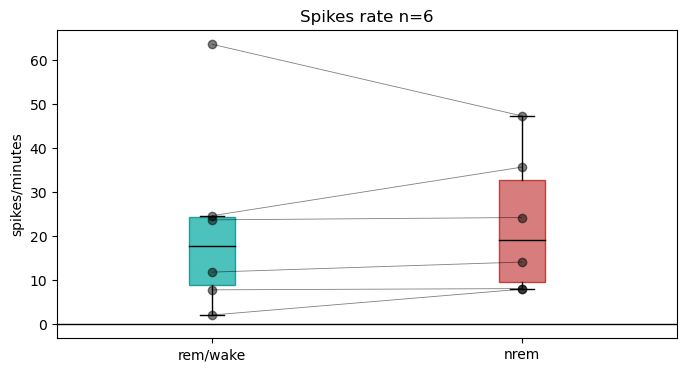

In [47]:
class SleepStage:
    def __init__(self, stage):
        self.stage = stage
        self.duration = 0
        self.spikes = 0
    
    def add_spike(self):
        self.spikes += 1
    
    def add_duration(self, start_time, end_time):
        self.duration += (end_time - start_time)

    @property
    def dureation_in_seconds(self):
        return self.duration / 1000
    
    @property
    def spikes_rate(self):
        return self.spikes / (self.dureation_in_seconds / 60)


def calcualte_spikes_rate(subj, separate_wake_and_rem=False):
    flat_features = np.load(s.paths.subject_flat_features_path)
    
    # if separate_wake_and_rem:
        # by default we group rem and wake stages together (to have consistent results of the detection and stimuli projects)
    utils.add_sleeping_stage_flag_to_spike_features(subj, flat_features, separate_wake_and_rem=separate_wake_and_rem)
    
    # get one rpresentative of each group
    group_ids = flat_features[:, GROUP_INDEX]
    unique_indices = np.unique(group_ids, return_index=True)[1]
    unique_group_subj_features = flat_features[unique_indices]
    hypnogram = unique_group_subj_features[:, HYPNOGRAM_FLAG_INDEX]

    if separate_wake_and_rem:
        hypnogram_flag_converter = DETECTION_HYPNOGRAM_FALGS_NAMES
    else:
        hypnogram_flag_converter = HYPNOGRAM_FLAGS_NAMES

    subj_stages = {
        stage: SleepStage(stage) for stage in hypnogram_flag_converter.values()
    }
    
    for h in hypnogram:
        stage = hypnogram_flag_converter[h]
        subj_stages[stage].add_spike()

    print(sleeping_utils.get_sleep_start_end_indexes(subj))
    changing_points, values = sleeping_utils.get_hypnogram_changes_in_miliseconds(subj, separate_wake_and_rem=separate_wake_and_rem)
    print(changing_points, values)
    for i in range(len(changing_points)):
        start_time = changing_points[i]
        if i == len(changing_points) - 1:
            # last stage - end of the recording - use the last spike time (not exactly accurate, but should be close enough for the purpose of the analysis)
            end_time = flat_features[-1, TIMESTAMP_INDEX]
        else:
            end_time = changing_points[i+1]
        stage = hypnogram_flag_converter[values[i]]
        subj_stages[stage].add_duration(start_time, end_time)
    

    for stage, stage_data in subj_stages.items():
        print(f"subject {subj.p_number} stage {stage} spikes rate {stage_data.spikes_rate} spikes {stage_data.spikes} duration {stage_data.dureation_in_seconds / 3600} hours")

    
    return subj_stages


if separate_wake_and_rem:
    hypnogram_flag_converter = DETECTION_HYPNOGRAM_FALGS_NAMES
else:
    hypnogram_flag_converter = HYPNOGRAM_FLAGS_NAMES


subject_stages = {}
stages = {
    stage: [] for stage in hypnogram_flag_converter.values()
}
for s in detection_subjects:
    subj_stages = calcualte_spikes_rate(s, separate_wake_and_rem=separate_wake_and_rem)
    subject_stages[s.p_number] = {}
    for stage, stage_data in subj_stages.items():
        stages[stage].append(stage_data.spikes_rate)
        subject_stages[s.p_number] = [stage_data.spikes_rate for stage_data in subj_stages.values()]

create_box_plot_for_stimuli(
    figure_path="",
    data_channels=stages,
    data_channels_linear=subject_stages,
    feature_name=f'Spikes rate n={len(detection_subjects)}',
    show=True
)
    
